In [ ]:
!nvidia-smi

Sun Feb 25 12:07:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
from tqdm.notebook import tqdm

In [ ]:
RANDOM_SEED = 42
torch.manual_seed(seed=RANDOM_SEED)
torch.cuda.manual_seed(seed=RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [ ]:
import tensorflow as tf
(train_X, train_y), (test_X, test_y) = tf.keras.datasets.mnist.load_data()

train_X = train_X.reshape((train_X.shape[0], -1))
test_X = test_X.reshape((test_X.shape[0], -1))

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((60000, 784), (60000,), (10000, 784), (10000,))

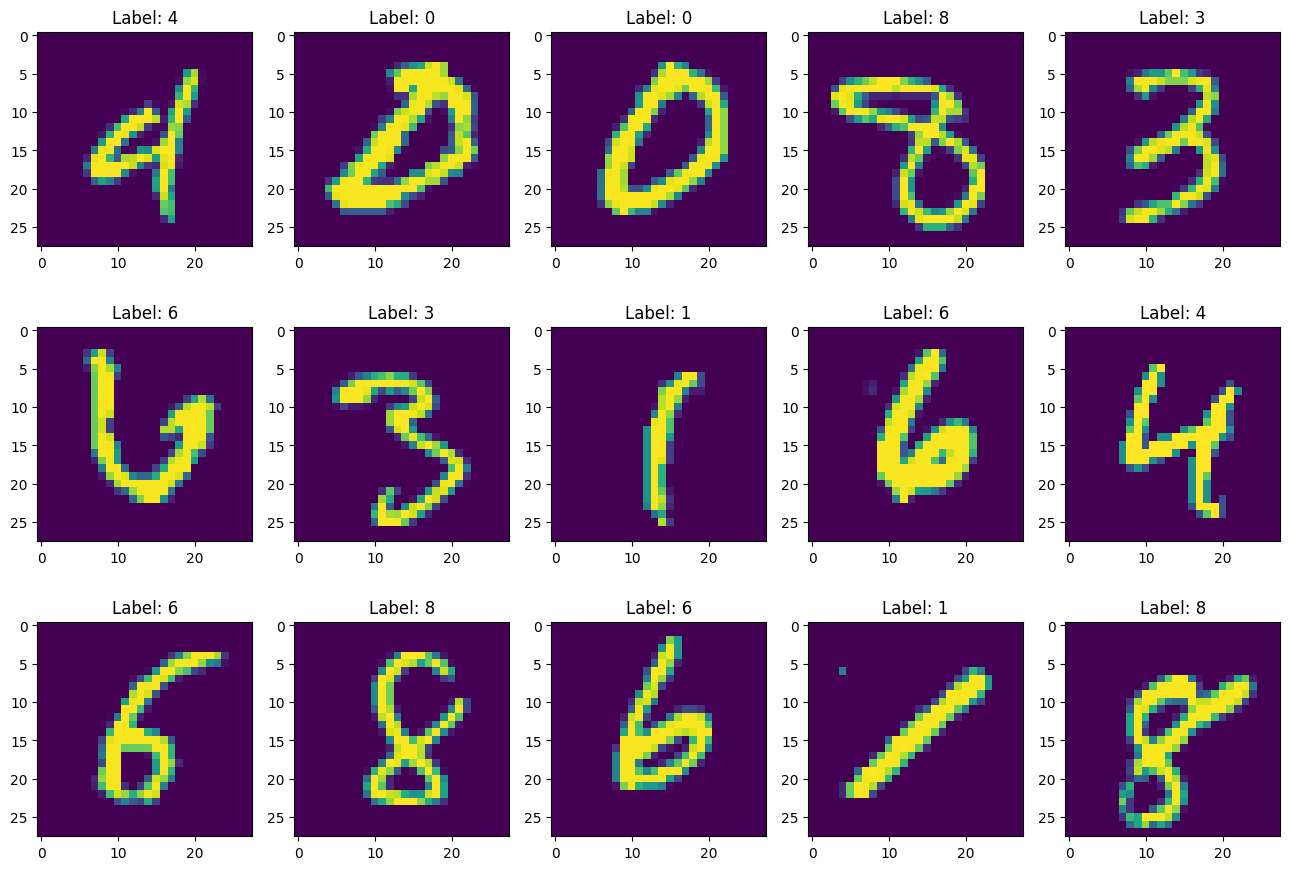

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(13, 9))

for i in range(3):
    for j in range(5):
        index = np.random.choice(train_X.shape[0])
        axes[i, j].imshow(train_X[index].reshape(28, 28))
        axes[i, j].set_title(f'Label: {train_y[index]}')

fig.tight_layout()
plt.show()

In [ ]:
# Normalize data
mean_X = train_X.mean()
std_X = train_X.std()
train_X = (train_X - mean_X) / std_X
test_X = (test_X - mean_X) / std_X

## Dataset and DataLoader

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.X = torch.tensor(data_x.astype('float32')).reshape(-1, 1, 28, 28)
        self.y = torch.tensor(data_y)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]


In [ ]:
train_dataset = MNISTDataset(train_X, train_y)
test_dataset = MNISTDataset(test_X, test_y)

In [ ]:
train_dataset.X.shape

torch.Size([60000, 1, 28, 28])

In [ ]:
batch_size = 1024
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for batch in train_dataloader:
    print(batch)
    break

[tensor([[[[-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          ...,
          [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241]]],


        [[[-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          ...,
          [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241]]],


        [[[-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
          [-0.4241, -0.42

In [ ]:
batch[0].shape, batch[1].shape

(torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

## Model

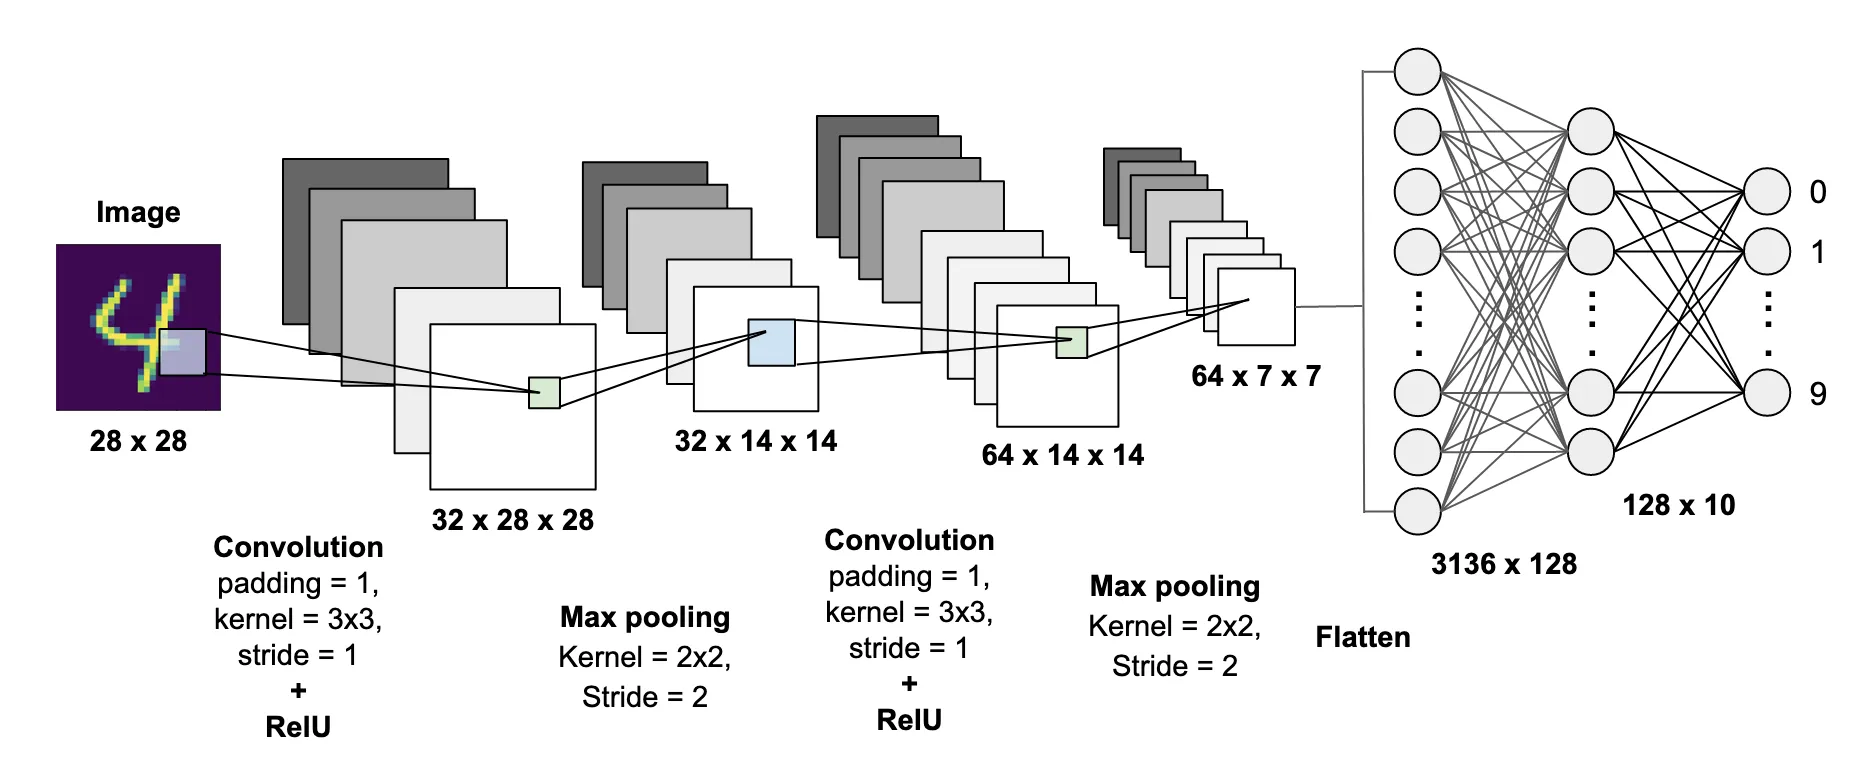

In [ ]:
3136 * 128 + 128

401536

In [ ]:
32 * 3 * 3 * 64 + 64

18496

In [ ]:
class BasicNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.input_size = input_size
        self.network = nn.Sequential(

            nn.Conv2d(in_channels=1, out_channels=32,
                      kernel_size=(3, 3), padding=1, stride=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=(3, 3), padding=1, stride=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            nn.Flatten(),
            nn.Linear(64 * self.input_size // (4**2), 128),
            nn.LeakyReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, X):
        return self.network(X)

In [ ]:
class BetterNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(in_channels=1, out_channels=8,
                      kernel_size=(3, 3), padding=1, stride=2),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=8, out_channels=16,
                      kernel_size=(3, 3), padding=1, stride=2),
            nn.LeakyReLU(),

            nn.Conv2d(in_channels=16, out_channels=32,
                      kernel_size=(3, 3), padding=1, stride=2),
            nn.LeakyReLU(),

            nn.Flatten(),
            nn.Linear(32*4*4, num_classes)
        )

    def forward(self, X):
        return self.network(X)

In [ ]:
class BestNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(in_channels=1, out_channels=8,
                      kernel_size=(3, 3), padding=1, stride=2),
            nn.BatchNorm2d(num_features=8),
            nn.LeakyReLU(),
            nn.Dropout2d(p=0.1),

            nn.Conv2d(in_channels=8, out_channels=16,
                      kernel_size=(3, 3), padding=1, stride=2),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(),
            nn.Dropout2d(p=0.1),

            nn.Conv2d(in_channels=16, out_channels=32,
                      kernel_size=(3, 3), padding=1, stride=2),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(),
            nn.Dropout2d(p=0.1),


            nn.Flatten(),
            nn.Linear(32*4*4, num_classes)
        )

    def forward(self, X):
        return self.network(X)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
my_basic_model = BasicNet(input_size=28*28, num_classes=10)
my_basic_model.to(device)

BasicNet(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=128, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
my_better_model = BetterNet(input_size=28*28, num_classes=10)
my_better_model.to(device)

BetterNet(
  (network): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
my_best_model = BestNet(input_size=28*28, num_classes=10)
my_best_model.to(device)

BestNet(
  (network): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout2d(p=0.1, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=512, out_features=10, bias=True)
  )
)

## Loss-function (criterion) and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer_for_basic_model = torch.optim.AdamW(my_basic_model.parameters(), lr=0.001)
optimizer_for_better_model = torch.optim.AdamW(my_better_model.parameters(), lr=0.001)
optimizer_for_best_model = torch.optim.AdamW(my_best_model.parameters(), lr=0.001)

## Train Loop

In [ ]:
w1 = torch.tensor([1.0], requires_grad=True)
w2 = torch.tensor([1.0], requires_grad=True)
w3 = torch.tensor([1.0], requires_grad=True)

In [ ]:
loss = w1 + w2 + w3**2

In [ ]:
loss.backward()

In [ ]:
w1.grad, w2.grad, w3.grad

(tensor([1.]), tensor([1.]), tensor([2.]))

In [ ]:
def train(model, criterion, optimizer,
          train_dataloader, test_dataloader, num_epochs):

    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)

    train_accuracy_arr = np.zeros(num_epochs)
    test_accuracy_arr = np.zeros(num_epochs)

    for i_epoch in tqdm(range(num_epochs)):
        train_loss = 0
        test_loss = 0

        train_accuracy = 0
        test_accuracy = 0

        # train step
        model.train()
        for batch in train_dataloader:
            X = batch[0].to(device)
            y = batch[1].to(device)

            # model forward-pass
            preds = model(X)

            # model backward-pass
            optimizer.zero_grad()
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

            # save loss and accuracy
            train_loss += loss.detach().cpu().numpy()
            train_accuracy += (preds.argmax(-1).detach() == y).cpu().numpy().mean()

        train_loss /= len(train_dataloader)
        train_accuracy /= len(train_dataloader)
        train_losses[i_epoch] = train_loss
        train_accuracy_arr[i_epoch] = train_accuracy

        # test step
        model.eval()
        for batch in test_dataloader:
            X = batch[0].to(device)
            y = batch[1].to(device)

            with torch.no_grad():
                # model forward-pass
                preds = model(X)
                loss = criterion(preds, y)

                # save loss and accuracy
                test_loss += loss.detach().cpu().numpy()
                test_accuracy += (preds.argmax(-1) == y).cpu().numpy().mean()


        test_loss /= len(test_dataloader)
        test_accuracy /= len(test_dataloader)

        test_losses[i_epoch] = test_loss
        test_accuracy_arr[i_epoch] = test_accuracy

    return train_losses, test_losses, train_accuracy_arr, test_accuracy_arr

## Basic model train

In [ ]:
model_total_params = sum(p.numel() for p in my_basic_model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')

Number of trainable parameters: 421642


In [ ]:
train_losses, \
    test_losses, \
    train_accuracy_arr, \
    test_accuracy_arr = train(my_basic_model, criterion=criterion,
                              optimizer=optimizer_for_basic_model,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              num_epochs=40)

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
basic_model_logs = dict(
    train_losses = train_losses,
    test_losses = test_losses,
    train_accuracy_arr = train_accuracy_arr,
    test_accuracy_arr = test_accuracy_arr
)

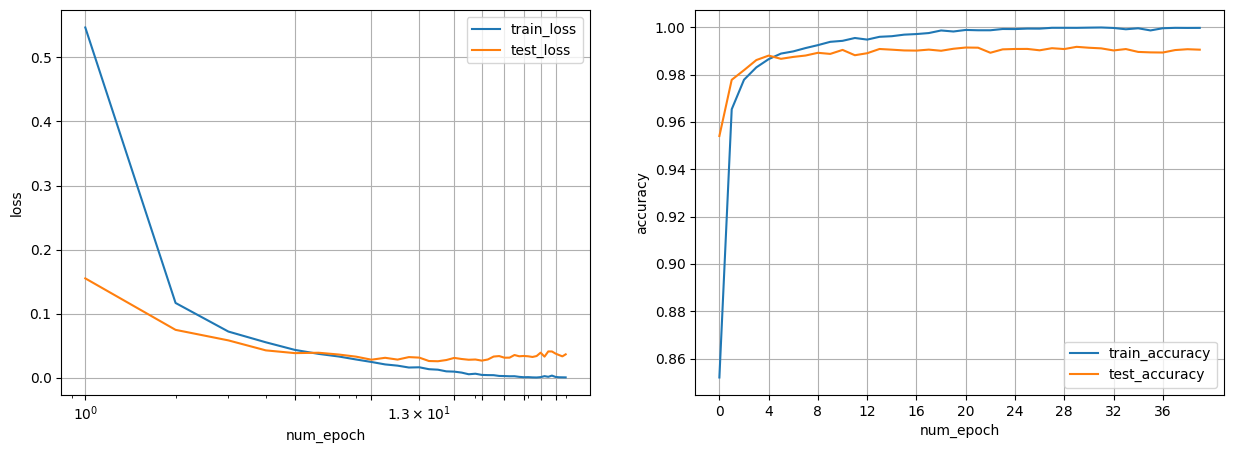

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].semilogx(np.arange(1, train_losses.shape[0] + 1), train_losses, label='train_loss')
ax[0].semilogx(np.arange(1, test_losses.shape[0] + 1), test_losses, label='test_loss')
ax[0].set_xticks(np.arange(1, train_losses.shape[0] + 1, 4))
ax[0].set_xlabel('num_epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[0].grid()

ax[1].plot(np.arange(train_accuracy_arr.shape[0]), train_accuracy_arr,
           label='train_accuracy')
ax[1].plot(np.arange(test_accuracy_arr.shape[0]), test_accuracy_arr,
           label='test_accuracy')
ax[1].set_xticks(np.arange(0, train_accuracy_arr.shape[0], 4))
ax[1].set_xlabel('num_epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
ax[1].grid()
plt.show()

In [ ]:
print(f'Best test_loss = {test_losses.min()}')
print(f'Best test_accuracy = {test_accuracy_arr.max()}')

Best test_loss = 0.026054957299493253
Best test_accuracy = 0.9917530293367347


### Results:

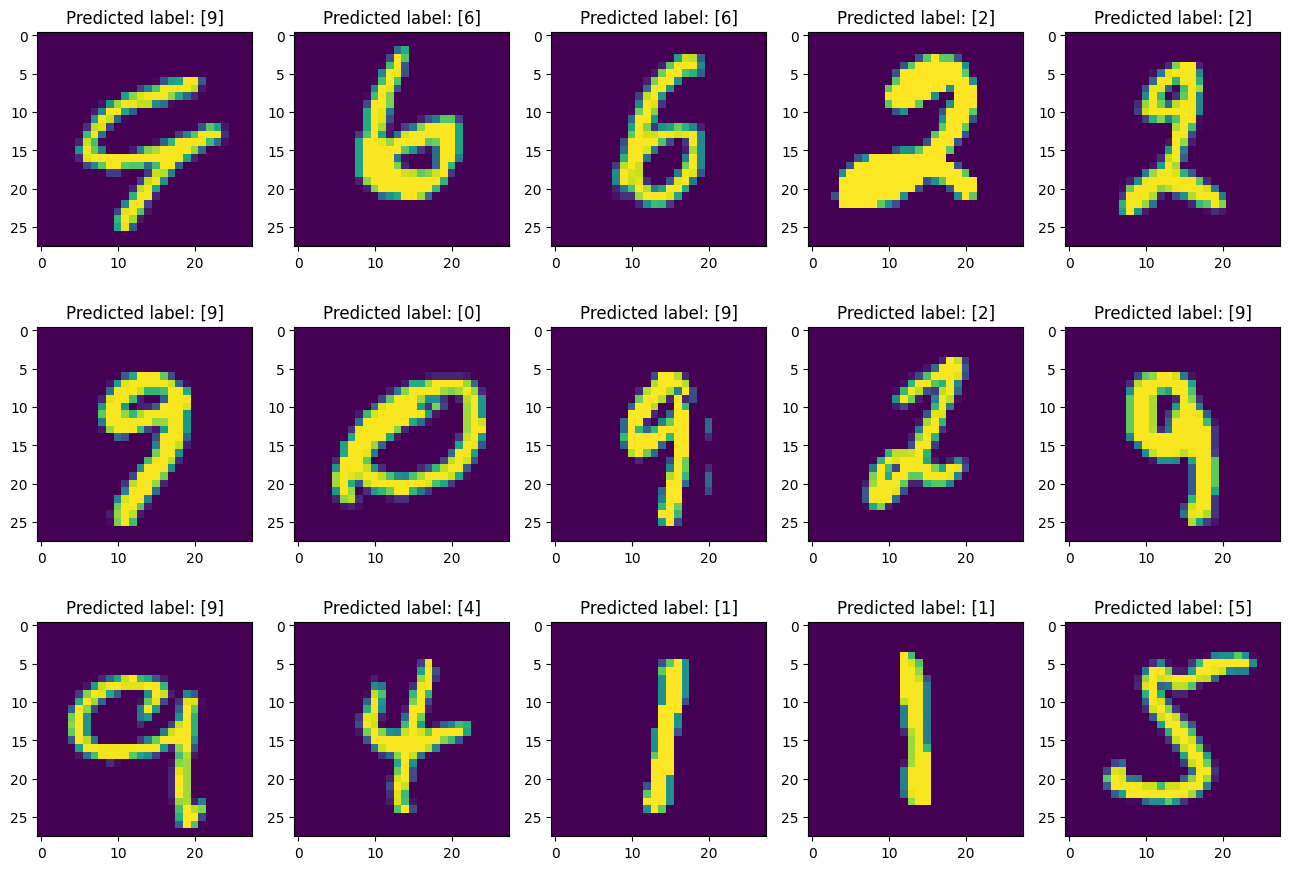

In [ ]:
fig, axes = plt.subplots(3, 5, figsize=(13, 9))

my_basic_model.eval()
for i in range(3):
    for j in range(5):
        index = np.random.choice(test_X.shape[0])
        axes[i, j].imshow(test_X[index].reshape(28, 28))
        with torch.no_grad():
            input_data = test_X[index].astype('float32').reshape(1, 28, 28)
            model_input = torch.tensor(input_data).unsqueeze(0).to(device)
            pred = my_basic_model(model_input).argmax(-1).cpu().numpy()
        axes[i, j].set_title(f'Predicted label: {pred}')

fig.tight_layout()
plt.show()

## Better model train

In [ ]:
model_total_params = sum(p.numel() for p in my_better_model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')

Number of trainable parameters: 11018


In [ ]:
train_losses, \
    test_losses, \
    train_accuracy_arr, \
    test_accuracy_arr = train(my_better_model, criterion=criterion,
                              optimizer=optimizer_for_better_model,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              num_epochs=60)

  0%|          | 0/60 [00:00<?, ?it/s]

In [ ]:
better_model_logs = dict(
    train_losses = train_losses,
    test_losses = test_losses,
    train_accuracy_arr = train_accuracy_arr,
    test_accuracy_arr = test_accuracy_arr
)

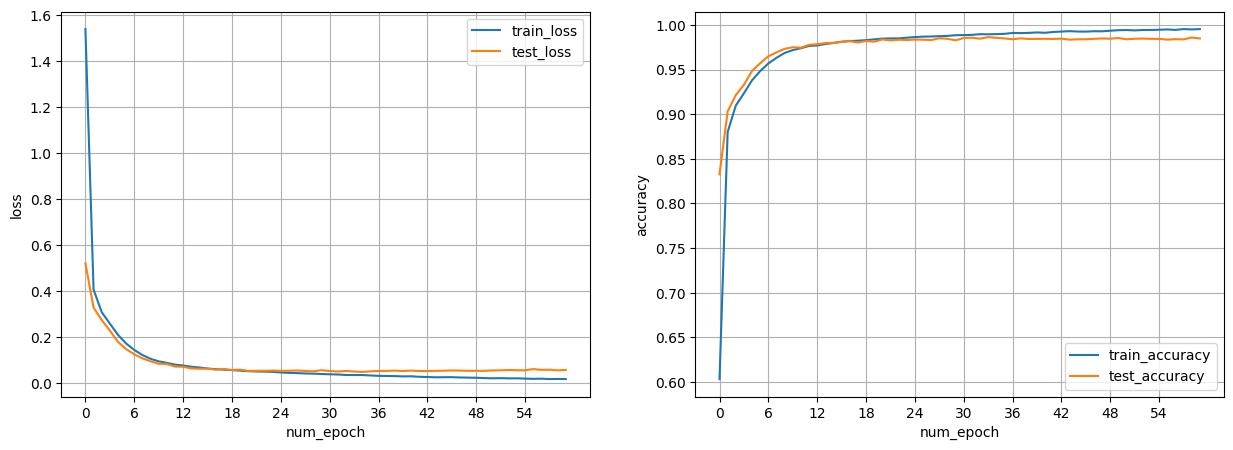

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].plot(np.arange(train_losses.shape[0]), train_losses, label='train_loss')
ax[0].plot(np.arange(test_losses.shape[0]), test_losses, label='test_loss')
ax[0].set_xticks(np.arange(0, train_losses.shape[0], 6))
ax[0].set_xlabel('num_epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[0].grid()

ax[1].plot(np.arange(train_accuracy_arr.shape[0]), train_accuracy_arr,
           label='train_accuracy')
ax[1].plot(np.arange(test_accuracy_arr.shape[0]), test_accuracy_arr,
           label='test_accuracy')
ax[1].set_xticks(np.arange(0, train_accuracy_arr.shape[0], 6))
ax[1].set_xlabel('num_epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
ax[1].grid()
plt.show()

In [ ]:
print(f'Best test_loss = {test_losses.min()}')
print(f'Best test_accuracy = {test_accuracy_arr.max()}')

Best test_loss = 0.04698724038898945
Best test_accuracy = 0.9863520408163264


## Best model train

In [ ]:
model_total_params = sum(p.numel() for p in my_best_model.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {model_total_params}')

Number of trainable parameters: 11130


In [ ]:
train_losses, \
    test_losses, \
    train_accuracy_arr, \
    test_accuracy_arr = train(my_best_model, criterion=criterion,
                              optimizer=optimizer_for_best_model,
                              train_dataloader=train_dataloader,
                              test_dataloader=test_dataloader,
                              num_epochs=60)

  0%|          | 0/60 [00:00<?, ?it/s]

In [ ]:
best_model_logs = dict(
    train_losses = train_losses,
    test_losses = test_losses,
    train_accuracy_arr = train_accuracy_arr,
    test_accuracy_arr = test_accuracy_arr
)

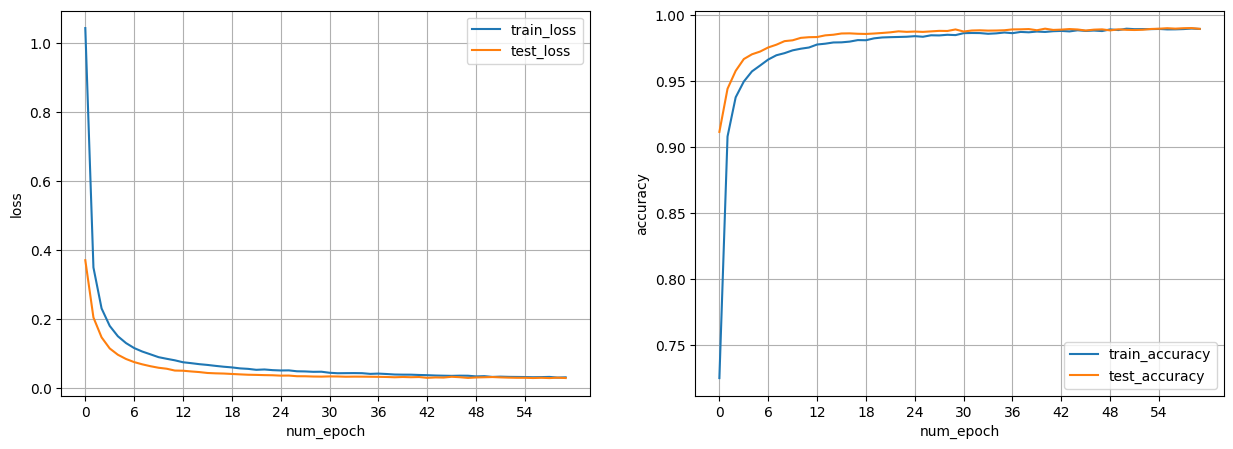

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].plot(np.arange(train_losses.shape[0]), train_losses, label='train_loss')
ax[0].plot(np.arange(test_losses.shape[0]), test_losses, label='test_loss')
ax[0].set_xticks(np.arange(0, train_losses.shape[0], 6))
ax[0].set_xlabel('num_epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[0].grid()

ax[1].plot(np.arange(train_accuracy_arr.shape[0]), train_accuracy_arr,
           label='train_accuracy')
ax[1].plot(np.arange(test_accuracy_arr.shape[0]), test_accuracy_arr,
           label='test_accuracy')
ax[1].set_xticks(np.arange(0, train_accuracy_arr.shape[0], 6))
ax[1].set_xlabel('num_epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
ax[1].grid()
plt.show()

In [ ]:
print(f'Best test_loss = {test_losses.min()}')
print(f'Best test_accuracy = {test_accuracy_arr.max()}')

Best test_loss = 0.029956292547285556
Best test_accuracy = 0.9900849011479591
